In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance

import category_encoders as ce
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline as mpipe

from scipy import stats
from itertools import combinations

import shap
import optuna
from optuna.samplers import TPESampler
from BorutaShap import BorutaShap

from lightgbm import LGBMClassifier

seed = 42
np.random.seed(seed)
pd.set_option('display.max_columns', None)

In [2]:
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def reduce_memory(df, verbose=0):
    if verbose != 0:
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    if verbose != 0:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def cross_validation(clf, X, y, scoring='f1'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall)
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix]

In [3]:
df = pd.read_excel('credit_cards.xls', header=1)
target = 'default payment next month'
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.drop('ID', axis=1).duplicated().sum()

35

In [5]:
df[target].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [7]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


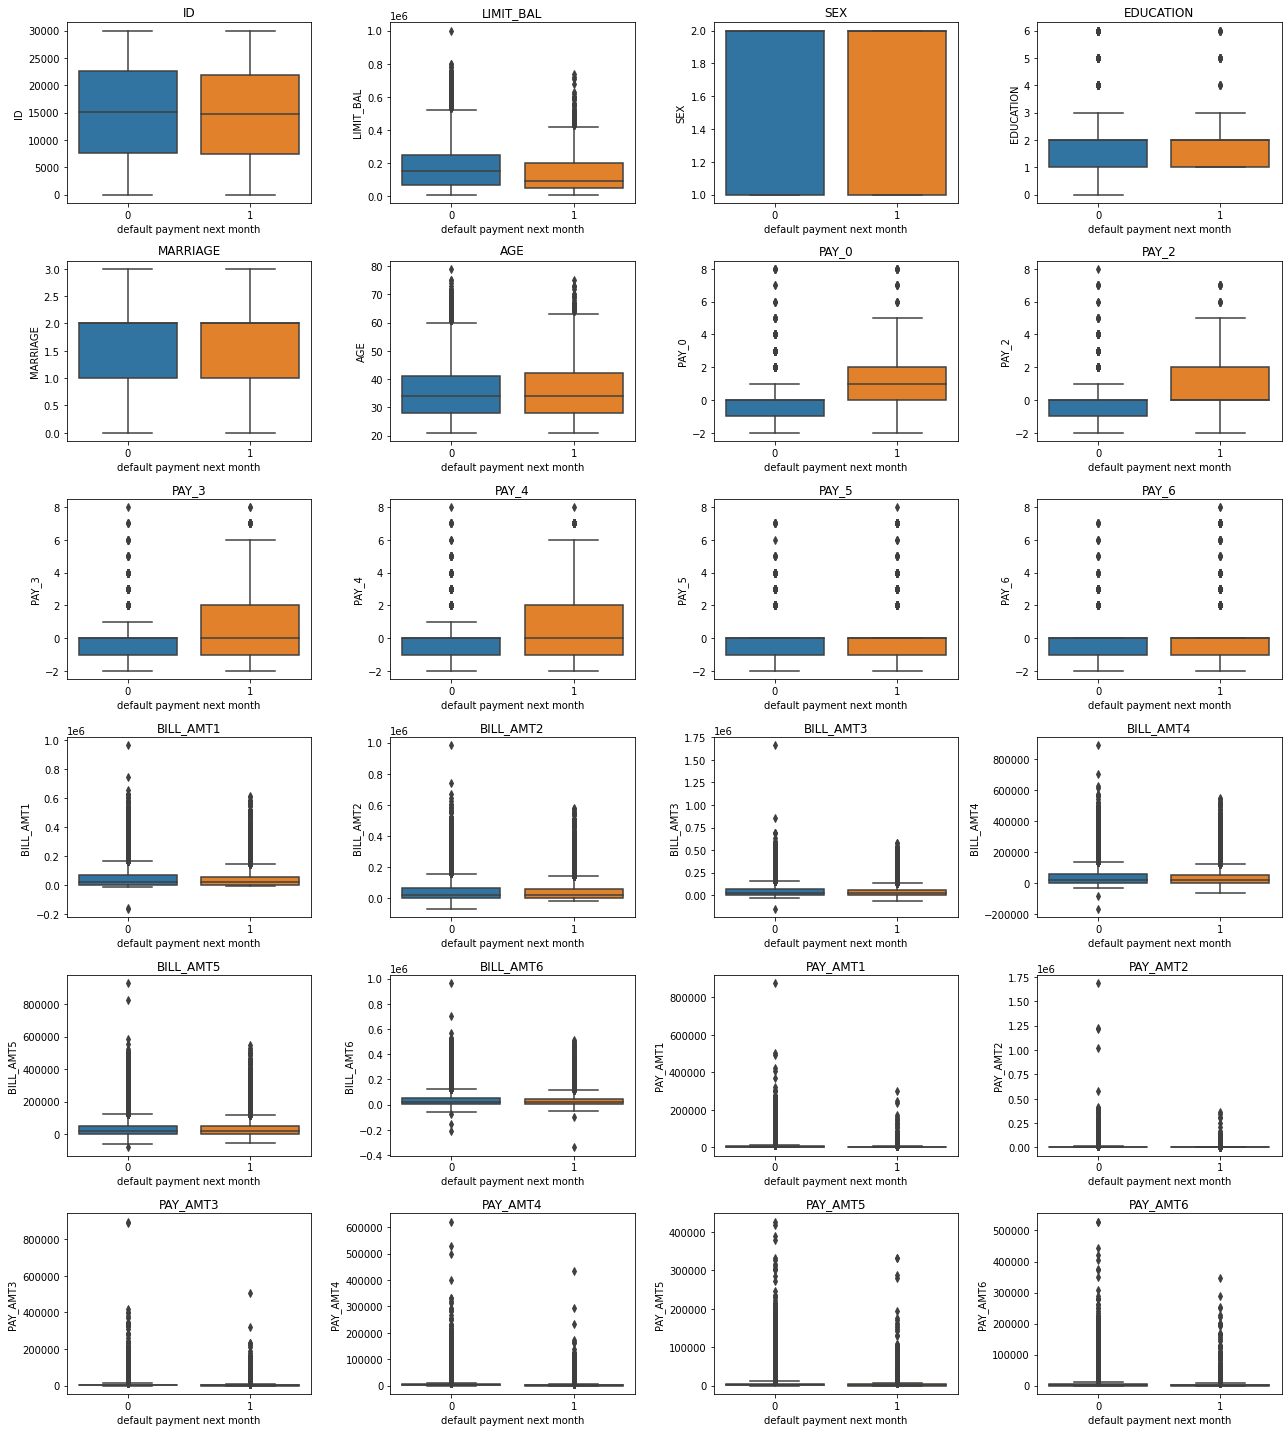

In [21]:
plt.figure(figsize=(18,20))
for idx, column in enumerate(df.select_dtypes(include='number').columns[:-1], 1):
    plt.subplot(6, 4, idx)
    sns.boxplot(y=df[column], x=df[target], data=df)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

In [8]:
df.drop('ID', axis=1, inplace=True)
df = reduce_memory(df)

In [9]:
X, y = df.drop(target, axis=1), df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)

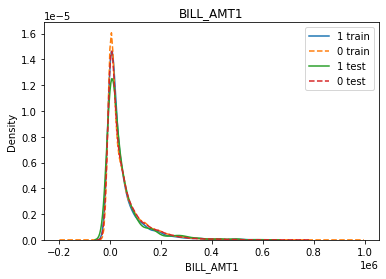

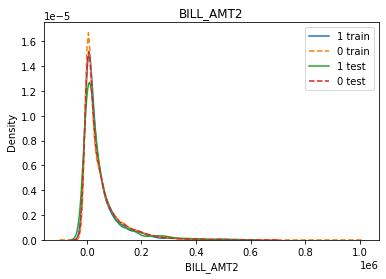

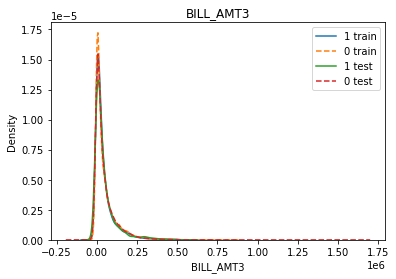

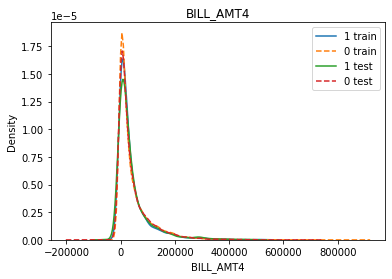

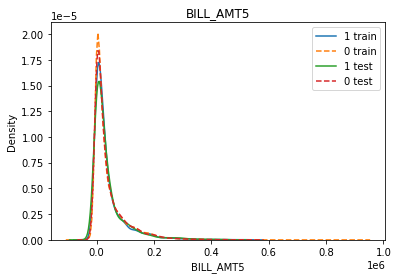

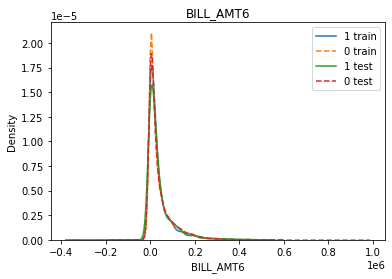

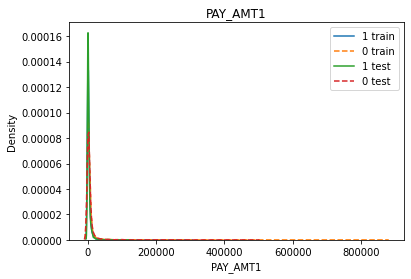

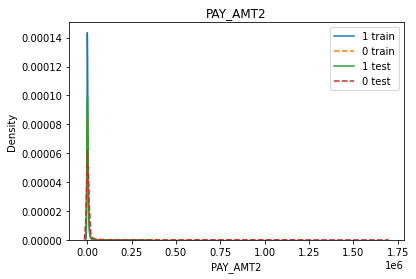

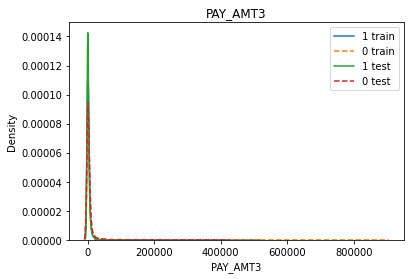

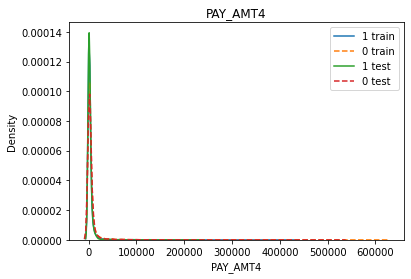

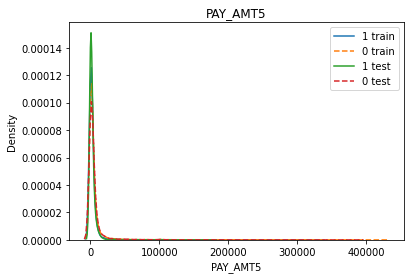

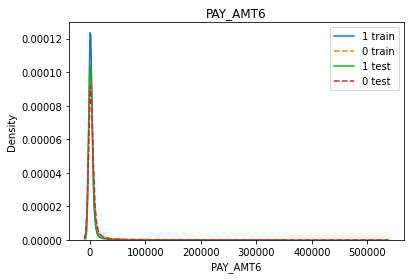

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:,2:].select_dtypes(include=numerics).columns:
    sns.kdeplot(X_train.loc[y_train == 1,i], label='1 train')
    sns.kdeplot(X_train.loc[y_train == 0,i], ls='--', label='0 train')
    
    sns.kdeplot(X_test.loc[y_test == 1,i], label='1 test')
    sns.kdeplot(X_test.loc[y_test == 0,i], ls='--', label='0 test')
    plt.title(i)
    plt.legend()
    plt.show()
# check whether train and test data have similar distribution

In [13]:
for i in X_train.iloc[:,2:].select_dtypes(include=numerics).columns:
    tr_test_stats = stats.mannwhitneyu(X_train.loc[y_train == 1, i], X_test.loc[y_test == 1, i])
    print(i, ':', tr_test_stats[1])
# check if test and train subsets have different distributions
# for binary features apply other stat tests: proportion z-test or chi_square (from statsmodels.stats import proportion)

BILL_AMT1 : 0.8083268007290692
BILL_AMT2 : 0.6976521426543164
BILL_AMT3 : 0.7151570484405396
BILL_AMT4 : 0.9055121734918611
BILL_AMT5 : 0.7004596925179732
BILL_AMT6 : 0.3840029629922843
PAY_AMT1 : 0.4634011792924779
PAY_AMT2 : 0.43230860759558487
PAY_AMT3 : 0.8627549972206862
PAY_AMT4 : 0.11905066213303434
PAY_AMT5 : 0.6501482379571042
PAY_AMT6 : 0.4832158221170486


In [35]:
r = permutation_importance(LGBMClassifier(verbose=-1).fit(X_train, y_train), X_test, y_test,
                            n_repeats=30, scoring='f1',
                            random_state=0)

In [36]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")  # overweight for PAY_0

PAY_0    0.222 +/- 0.007
PAY_3    0.020 +/- 0.003
BILL_AMT1 0.017 +/- 0.004
PAY_2    0.015 +/- 0.002
PAY_6    0.011 +/- 0.002
LIMIT_BAL 0.009 +/- 0.003
PAY_5    0.009 +/- 0.002
PAY_AMT2 0.006 +/- 0.003
PAY_AMT1 0.006 +/- 0.002
BILL_AMT5 0.004 +/- 0.003
PAY_AMT3 0.004 +/- 0.002
PAY_AMT5 0.004 +/- 0.002
PAY_4    0.004 +/- 0.001
AGE      0.003 +/- 0.002
EDUCATION 0.003 +/- 0.002
SEX      0.002 +/- 0.001
PAY_AMT6 0.002 +/- 0.002
BILL_AMT6 0.002 +/- 0.002
PAY_AMT4 0.001 +/- 0.002
MARRIAGE -0.000 +/- 0.002
BILL_AMT2 -0.000 +/- 0.003
BILL_AMT3 -0.002 +/- 0.003
BILL_AMT4 -0.012 +/- 0.003


In [61]:
def statistic_output(*columns, df=df, target=target, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    for column in columns:
        print(column)
        categories = data[column].unique().tolist()
        for pair in combinations(categories, r=2):
            a, b = pair
            try:
                data_ = data.loc[data[column].isin(pair), ['ID', column, target]].sample(sample_size, random_state=1)
                table = data_.pivot_table(values='ID', index=column, columns=target, aggfunc='count')
            except ValueError:
                continue
            _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
            if pvalue >= alpha:
                print(f'Categories {a} and {b} can be united. P-value: {pvalue:.6f}')
            else:
                print(f'Categories {a} and {b} have different frequencies with target.')

In [14]:
base_boruta_params = {'model': LGBMClassifier(verbose=-1, 
                                              is_unbalance=True, 
                                              random_state=seed), 
                      'importance_measure': 'shap', 
                      'classification': True}

class BorutaSelection(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.selector = BorutaShap(**kwargs)
        
    def fit(self, X, y=None):
        self.selector.fit(X, y, n_trials=20, sample=True, verbose=False)
        return self
    
    def transform(self, X):
        drop_columns = self.selector.features_to_remove
        return X.drop(drop_columns, axis=1)
    
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_bins = None
        self.pay_dicts = []
        self.pay_medians = []
        self.forest = IsolationForest(n_estimators=200, contamination=0.03, bootstrap=True, n_jobs=-1, random_state=42)
        self.log_columns = []
        
    def fit(self, X, y=None):
        self.log_columns = [col for col in X.columns if col.startswith(('LIMIT', 'BILL_AMT', 'PAY_AMT'))]
        self.age_bins = np.linspace(X.AGE.min()-1, X.AGE.max()+1, 6)
        data = pd.concat([X, y],axis=1)
        for i in range(6):
            tmp = data.groupby(f'PAY_{i+1}')[target].mean()
            self.pay_dicts.append(tmp.to_dict())
            self.pay_medians.append(tmp.median())
        self.forest.fit(X.drop('ID', axis=1))
        return self
    
    def transform(self, X):
        X = X.copy()
        X.drop('ID', axis=1, inplace=True)
        
        outliers = self.forest.predict(X)
        X['SUSP'] = 0
        X.loc[outliers == -1, 'SUSP'] = 1
        
        X.SEX = X.SEX.map({1:0, 2:1}).astype(np.uint8)
        
        #for column in self.log_columns:
        #    X[f'{column}_log'] = np.log(np.abs(X[column])+1)
        
        X.loc[X.MARRIAGE == 0, 'MARRIAGE'] = 3
        X['SE_MA_2'] = 0
        X.loc[((X.SEX == 1) & (X.MARRIAGE == 1)) , 'SE_MA_2'] = 1 #married man
        X.loc[((X.SEX == 1) & (X.MARRIAGE == 2)) , 'SE_MA_2'] = 2 #single man
        X.loc[((X.SEX == 1) & (X.MARRIAGE == 3)) , 'SE_MA_2'] = 3 #divorced man
        X.loc[((X.SEX == 2) & (X.MARRIAGE == 1)) , 'SE_MA_2'] = 4 #married woman
        X.loc[((X.SEX == 2) & (X.MARRIAGE == 2)) , 'SE_MA_2'] = 5 #single woman
        X.loc[((X.SEX == 2) & (X.MARRIAGE == 3)) , 'SE_MA_2'] = 6 #divorced woman
        
        X['AgeBin'] = pd.to_numeric(pd.cut(X.AGE, bins=self.age_bins, labels=[1,2,3,4,5]))
        X['AgeBin'].fillna(X['AgeBin'].mode()[0], inplace=True)
        
        X.loc[((X.SEX == 1) & (X.AgeBin == 1)) , 'SE_AG'] = 1 #man in 20's
        X.loc[((X.SEX == 1) & (X.AgeBin == 2)) , 'SE_AG'] = 2 #man in 30's
        X.loc[((X.SEX == 1) & (X.AgeBin == 3)) , 'SE_AG'] = 3 #man in 40's
        X.loc[((X.SEX == 1) & (X.AgeBin == 4)) , 'SE_AG'] = 4 #man in 50's
        X.loc[((X.SEX == 1) & (X.AgeBin == 5)) , 'SE_AG'] = 5 #man in 60's and above
        X.loc[((X.SEX == 2) & (X.AgeBin == 1)) , 'SE_AG'] = 6 #woman in 20's
        X.loc[((X.SEX == 2) & (X.AgeBin == 2)) , 'SE_AG'] = 7 #woman in 30's
        X.loc[((X.SEX == 2) & (X.AgeBin == 3)) , 'SE_AG'] = 8 #woman in 40's
        X.loc[((X.SEX == 2) & (X.AgeBin == 4)) , 'SE_AG'] = 9 #woman in 50's
        X.loc[((X.SEX == 2) & (X.AgeBin == 5)) , 'SE_AG'] = 10 #woman in 60's and above
        
        X['Client_6'] = 1
        X['Client_5'] = 1
        X['Client_4'] = 1
        X['Client_3'] = 1
        X['Client_2'] = 1
        X['Client_1'] = 1
        X.loc[((X.PAY_6 == 0) & (X.BILL_AMT6 == 0) & (X.PAY_AMT6 == 0)) , 'Client_6'] = 0
        X.loc[((X.PAY_5 == 0) & (X.BILL_AMT5 == 0) & (X.PAY_AMT5 == 0)) , 'Client_5'] = 0
        X.loc[((X.PAY_4 == 0) & (X.BILL_AMT4 == 0) & (X.PAY_AMT4 == 0)) , 'Client_4'] = 0
        X.loc[((X.PAY_3 == 0) & (X.BILL_AMT3 == 0) & (X.PAY_AMT3 == 0)) , 'Client_3'] = 0
        X.loc[((X.PAY_2 == 0) & (X.BILL_AMT2 == 0) & (X.PAY_AMT2 == 0)) , 'Client_2'] = 0
        X.loc[((X.PAY_1 == 0) & (X.BILL_AMT1 == 0) & (X.PAY_AMT1 == 0)) , 'Client_1'] = 0
        
        X['Avg_exp_5'] = ((X['BILL_AMT5'] - (X['BILL_AMT6'] - X['PAY_AMT5']))) / X['LIMIT_BAL']
        X['Avg_exp_4'] = (((X['BILL_AMT5'] - (X['BILL_AMT6'] - X['PAY_AMT5'])) + 
                            (X['BILL_AMT4'] - (X['BILL_AMT5'] - X['PAY_AMT4']))) / 2) / X['LIMIT_BAL']
        X['Avg_exp_3'] = (((X['BILL_AMT5'] - (X['BILL_AMT6'] - X['PAY_AMT5'])) + 
                            (X['BILL_AMT4'] - (X['BILL_AMT5'] - X['PAY_AMT4'])) +
                            (X['BILL_AMT3'] - (X['BILL_AMT4'] - X['PAY_AMT3']))) / 3) / X['LIMIT_BAL']
        X['Avg_exp_2'] = (((X['BILL_AMT5'] - (X['BILL_AMT6'] - X['PAY_AMT5'])) +
                          (X['BILL_AMT4'] - (X['BILL_AMT5'] - X['PAY_AMT4'])) +
                          (X['BILL_AMT3'] - (X['BILL_AMT4'] - X['PAY_AMT3'])) +
                          (X['BILL_AMT2'] - (X['BILL_AMT3'] - X['PAY_AMT2']))) / 4) / X['LIMIT_BAL']
        X['Avg_exp_1'] = (((X['BILL_AMT5'] - (X['BILL_AMT6'] - X['PAY_AMT5'])) +
                          (X['BILL_AMT4'] - (X['BILL_AMT5'] - X['PAY_AMT4'])) +
                          (X['BILL_AMT3'] - (X['BILL_AMT4'] - X['PAY_AMT3'])) +
                          (X['BILL_AMT2'] - (X['BILL_AMT3'] - X['PAY_AMT2'])) +
                          (X['BILL_AMT1'] - (X['BILL_AMT2'] - X['PAY_AMT1']))) / 5) / X['LIMIT_BAL']
        
        X['COUNT'] = X['PAY_AMT1'] + X['PAY_AMT2'] + X['PAY_AMT3'] + X['PAY_AMT4'] + X['PAY_AMT5'] + X['PAY_AMT6']
        
        weights = np.arange(1,7)
        X['WINDOW'] = X[['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']].rolling(6, axis=1).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True).iloc[:,-1]
        
        for i in range(6):
            X[f'PAY_TAR_{i}'] = X[f'PAY_{i+1}'].map(self.pay_dicts[i])
            X[f'PAY_TAR_{i}'].fillna(self.pay_medians[i])
        
        X = pd.get_dummies(X, columns=['EDUCATION', 'MARRIAGE', 'SE_AG', 'SE_MA_2'])
        
        X = reduce_memory(X)
        return X

In [15]:
df = pd.read_excel('credit_cards.xls', header=1)
df.drop_duplicates(subset=df.columns[1:], inplace=True)

df = df.rename(columns={'PAY_0': 'PAY_1'})
X, y = df.drop(target, axis=1), df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train,
                                                     random_state=seed)
print(f'Train size: {len(y_train)}, validation size: {len(y_valid)}, test size: {len(y_test)}')

Train size: 20225, validation size: 2248, test size: 7492


In [16]:
pipe = mpipe(Preprocessor(), 
             BorutaSelection(**base_boruta_params)).fit(X_train, y_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [463]:
pipe[-1].selector.features_to_remove

array(['SEX', 'AGE', 'PAY_4', 'PAY_6', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT5', 'PAY_AMT6',
       'SUSP', 'AgeBin', 'Client_6', 'Client_5', 'Client_4', 'Client_3',
       'Client_2', 'Client_1', 'Avg_exp_5', 'Avg_exp_4', 'Avg_exp_2',
       'COUNT', 'PAY_TAR_1', 'PAY_TAR_2', 'PAY_TAR_3', 'PAY_TAR_4',
       'PAY_TAR_5', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
       'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'SE_AG_1.0', 'SE_AG_2.0',
       'SE_AG_3.0', 'SE_AG_4.0', 'SE_AG_5.0', 'SE_MA_2_0', 'SE_MA_2_1',
       'SE_MA_2_2', 'SE_MA_2_3'], dtype=object)

In [22]:
X_train = pipe.transform(X_train)
X_valid = pipe.transform(X_valid)
X_test = pipe.transform(X_test)

In [356]:
base = LGBMClassifier(verbose=-1, is_unbalance=True, random_state=seed) # not in pipeline to speed up process 

In [357]:
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=-1)

base_train = base.predict(X_train)
base_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_train, y_test, base_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.923     0.826     0.871     15750
           1      0.552     0.756     0.638      4475

    accuracy                          0.810     20225
   macro avg      0.737     0.791     0.755     20225
weighted avg      0.841     0.810     0.820     20225

Test
               precision    recall  f1-score   support

           0      0.881     0.799     0.838      5834
           1      0.467     0.621     0.533      1658

    accuracy                          0.759      7492
   macro avg      0.674     0.710     0.685      7492
weighted avg      0.789     0.759     0.770      7492

Train ROC_AUC: 0.880, Test ROC_AUC: 0.771
Confusion Matrix 
 col_0                          0     1
default payment next month            
0                           4660  1174
1                            629  1029


In [19]:
def lgb_f1_score(labels, scores):
    pred_labels = np.round(scores)
    return 'f1', f1_score(labels, pred_labels), True

model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 2000,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': seed
}
fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': lgb_f1_score,
              'verbose': False
}

In [359]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 60, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 120, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }
    param_trials.update(model_params)
    opt_model = LGBMClassifier(**param_trials)
    opt_model.fit(X_train, y_train, **fit_params)
    
    y_pred = opt_model.predict(X_valid)
    score = f1_score(y_valid, y_pred)
    
    return score

In [360]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=500, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Number of completed trials: 500
Best trial
Best score: 0.5494276795005203
Best params
max_depth: 9
learning_rate: 0.48966563514643024
reg_alpha: 1.4812898052991672
reg_lambda: 2.1385423876694607
num_leaves: 82
subsample: 0.3379383006101969
colsample_bytree: 0.6074592391411392
max_bin: 250
min_child_samples: 128
min_child_weight: 0.03815445417334891
boosting_type: gbdt


In [23]:
model_params = {
                'objective': 'binary',
                'n_estimators': 2000,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': seed,
                'boosting_type': 'goss',
                'colsample_bytree': 0.5643408045284101,
                'learning_rate': 0.48958948970188376,
                'max_bin': 251,
                'max_depth': 9,
                'learning_rate': 0.48966563514643024,
                'reg_alpha': 1.4812898052991672,
                'reg_lambda': 2.1385423876694607,
                'num_leaves': 82,
                'subsample': 0.3379383006101969,
                'colsample_bytree': 0.6074592391411392,
                'max_bin': 250,
                'min_child_samples': 128,
                'min_child_weight': 0.03815445417334891,
                'boosting_type': 'goss'
}
fit_params = {'early_stopping_rounds': 50,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': lgb_f1_score,
              'verbose': False
}

In [24]:
lgbm = LGBMClassifier(**model_params).fit(X_train, y_train, **fit_params)

train_preds = lgbm.predict(X_train)
test_preds = lgbm.predict(X_test)
train_proba = lgbm.predict_proba(X_train)[:,1]
test_proba = lgbm.predict_proba(X_test)[:,1]

report(y_train, train_preds, y_test, test_preds, train_proba, test_proba)

Train
               precision    recall  f1-score   support

           0      0.871     0.875     0.873     15750
           1      0.553     0.542     0.547      4475

    accuracy                          0.802     20225
   macro avg      0.712     0.709     0.710     20225
weighted avg      0.800     0.802     0.801     20225

Test
               precision    recall  f1-score   support

           0      0.863     0.874     0.868      5834
           1      0.534     0.510     0.522      1658

    accuracy                          0.793      7492
   macro avg      0.699     0.692     0.695      7492
weighted avg      0.790     0.793     0.792      7492

Train ROC_AUC: 0.790, Test ROC_AUC: 0.758
Confusion Matrix 
 col_0                          0    1
default payment next month           
0                           5097  737
1                            812  846


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, test_proba)

fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)

print(f'Best threshold: {thresholds[ix]:.3f}, F-score: {fscore[ix]:.3f}, Recall: {recall[ix]:.3f}, Precision: {precision[ix]:.3f}.')

Best threshold: 0.462, F-score: 0.526, Recall: 0.530, Precision: 0.521.


#### Synthetic A/B test

In [32]:
X_A, X_B, y_A, y_B = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

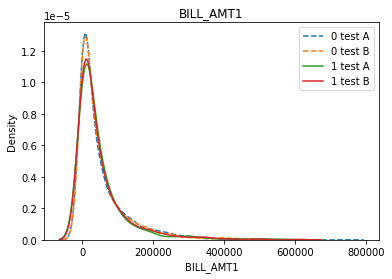

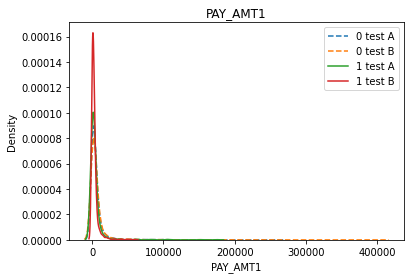

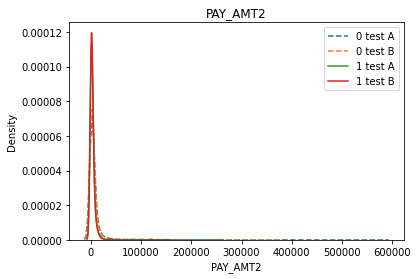

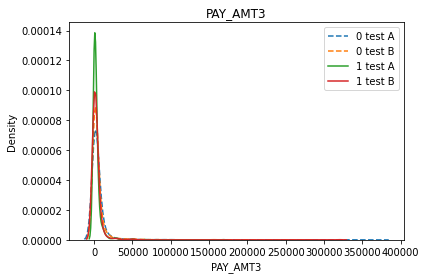

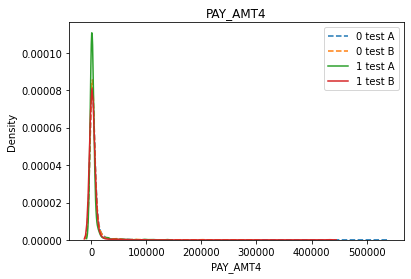

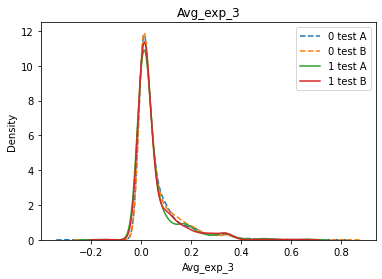

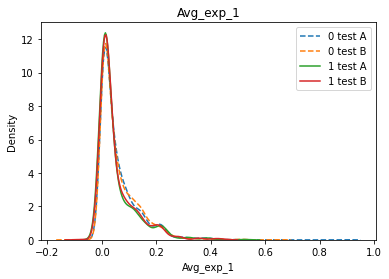

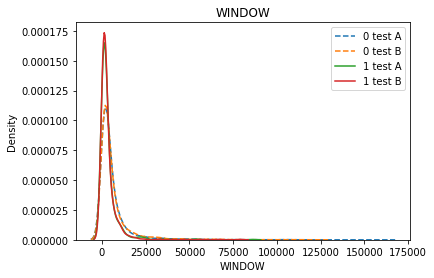

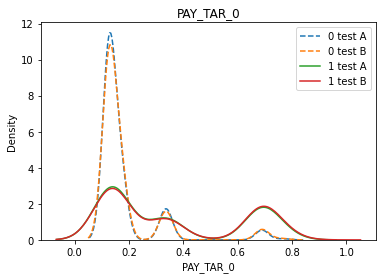

In [33]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:, 2:].select_dtypes(include=numerics).columns:
    sns.kdeplot(X_A.loc[y_A == 0,i], ls='--', label='0 test A')
    sns.kdeplot(X_B.loc[y_B == 0,i], ls='--', label='0 test B')
    
    sns.kdeplot(X_A.loc[y_A == 1,i], label='1 test A')
    sns.kdeplot(X_B.loc[y_B == 1,i], label='1 test B')
    plt.title(i)
    plt.legend()
    plt.show() 

In [35]:
from sklearn.metrics import confusion_matrix

predsB = lgbm.predict_proba(X_B)[:, 1]
cnf_matrix = confusion_matrix(y_B, predsB > thresholds[ix])

In [36]:
y_pred = (predsB > thresholds[ix])
ind_churn = np.where((y_pred != y_B) & (y_B == 1))  # FN actually
y_churnB = np.zeros(y_B.shape)
y_churnB[ind_churn] = 1


k1, n1 = np.sum(y_A), y_A.shape[0]
k2, n2 = np.sum(y_churnB), y_churnB.shape[0]

In [37]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=12.768 pvalue=0.000


In [38]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=163.034 pvalue=0.000


### So the difference between ML approach and no ML has statistical significance

### Shap

In [26]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_test.iloc[1,:], link='logit')

In [28]:
shap.force_plot(explainer.expected_value[1], shap_values[1][4,:], X_test.iloc[4,:], link='logit')

In [29]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_test.iloc[idx,:], link='logit')

In [30]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_test.iloc[idx,:], link='logit')

In [31]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_test.iloc[idx,:], link='logit')

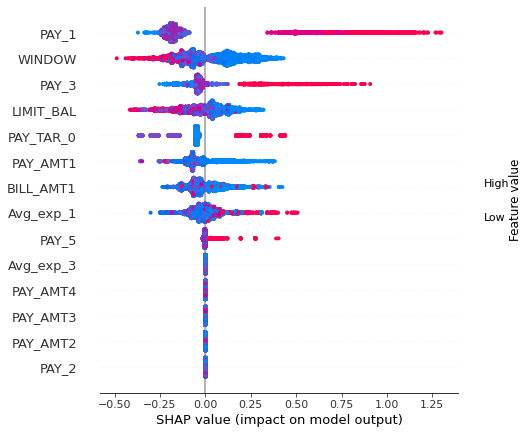

In [519]:
shap.summary_plot(shap_values[1], X_test)

Сильная зависимость от факта оплаты по кредиту (ближайший и третий месяц), в том числе усредненной за 6 месяцев (похоже, если размер выплат снижется от месяца к месяцу более вероятен дефолт. Что не всегда логично - клиент может завершать оплату по кредитному продукту... Впрочем признак не очень прозрачный, попытка провести некую аналогию с взвешенным временным рядом).